# Financial Econometrics I: Homework 2
Jan Kubal & Matyáš Mattanelli

## Problem 1
### Loading data

We randomly selected 100 tickers out of the provided set using the sample() function without replacement. The SIS number of Matyáš served as the seed number. Then, we downloaded data for selected tickers from Yahoo Finance using the functionality of quantmod package and restricting the time range to the one specified in the assignment.

In [ ]:
#Loading necessary packages
suppressPackageStartupMessages({
library(quantmod)
library(rugarch)
library(tseries)
library(forecast)
})

In [2]:
#Loading the file containing the symbols
symbols2 <- read.csv("symbols2.csv")

#Generating 100 random numbers
set.seed(48983854) #random seed using the SIS number
indices <- sort(sample(1:377, 100, replace = F)) #geting sample, sorting from lowest to highest

#Extracting the tickers
tickers <- symbols2$Symbol[indices]

#Downloading the data for each ticker
tickers_data <- vector("list", length(tickers)) #Empty list for the data
options("getSymbols.warning4.0" = FALSE) #To suppress an annoying message
for (i in 1:length(tickers)) {
    tickers_data[[i]] <- getSymbols(tickers[i], src = "yahoo", auto.assign = F, from = "2019-01-01", to = "2022-01-01")
}

Warning message:
"BMS contains missing values. Some functions will not work if objects contain missing values in the middle of the series. Consider using na.omit(), na.approx(), na.fill(), etc to remove or replace them."


Further, we work only with the closing prices adjusted for splits and dividends (and/or capital gain distributions). This variable is (in case of yahoo finance) standardly located in the sixth column but, for completness, we include a check of this in the next cell.

In [3]:
#Check that the adjusted closing price is in the sixth column
sixth_cols <- vector("character", length(tickers_data))
is_adjusted <- vector("character", length(tickers_data))

for(i in 1:length(tickers_data)) {
 sixth_cols[i] <- names(tickers_data[[i]])[6]
}

for(i in 1:length(tickers_data)) {
 is_adjusted[i] <- substr(sixth_cols[i],  nchar(sixth_cols[i])-nchar("Adjusted")+1, nchar(sixth_cols[i])) #selecting only last eight characters of each column name
}

sum(is_adjusted == "Adjusted") #If we get here sum of 100, we got all the adjusted closing prices in the sixth column and can continue with the analysis

[1] 100

In the subsequent step, we merge the acquired data into a single xts object. This will facilitate and expedite the future calculations. In addition, we preserve the whole time range and gain better control over the missing values.

In [4]:
#Merging into a single xts object
adjusted_prices <- merge.xts(tickers_data[[1]][, 6], tickers_data[[2]][, 6]) #Initial merge
for (i in 3:100) { #Loop to merge all 100 tickers
    adjusted_prices <- merge.xts(adjusted_prices,tickers_data[[i]][, 6])
}

### 1) Log-returns

Bellow, we compute the logarithmic returns on the stocks of our interest. This is done using the formula for logarithmic returns: $log(R_t) = log(\frac{P_t - P_{t-1}}{P_{t-1}}) = log(\frac{P_t}{P{t-1}}-\frac{P_{t-1}}{P{t-1}}) = log(\frac{P_t}{P{t-1}}) - log(1) = log(P_t) - log(P_{t-1})$.

In [5]:
#Log-returns
log_returns <- log(adjusted_prices) - log(lag(adjusted_prices)) #Given the nature of the xts object, the operation is performed on each column separately

For illustration, we plot all of the resulting log-returns below.

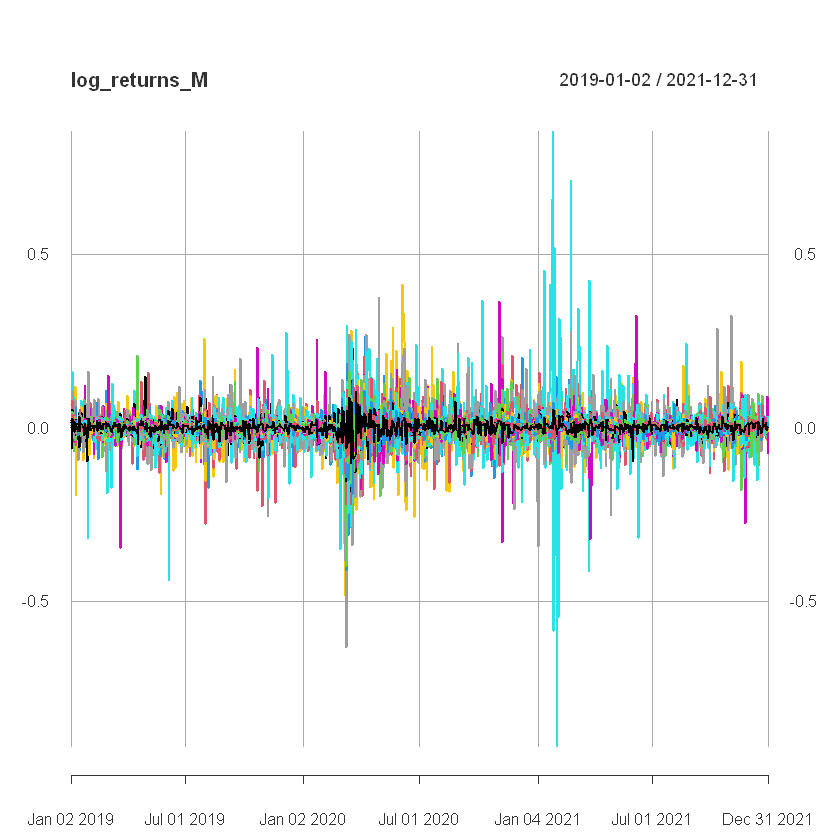

In [6]:
#Plotting the log-returns
plot(log_returns)

---

In [7]:
#Creating list containing Log-returns
log_returns <- vector("list", length(tickers_data)) #initializing empty list, to be filled with dataframes

for(i in 1:length(tickers_data)) {
    obs <- length(tickers_data[[i]][,6]) #number of observations of adjusted close price for ith ticker
    lrets <- vector("numeric", obs)
    lrets[1] <- NA

    for(n in 2:obs){
        lrets[n] <- as.numeric(log(tickers_data[[i]][n,6])) - as.numeric(log(tickers_data[[i]][n-1,6])) #cpmuting the log-returns
    }

    log_returns[[i]] <- data.frame(Date = index(tickers_data[[i]]), tickers_data[[i]][,6], Log_returns = lrets) #saving log-returns and othe info in dataframe
}

#Each element of the list log_returns is a dataframe, containing dates, original closing prices and logarithmic returns
#(the original prices is included mainly so the firm it belongs to could be easily recognized by ticker)

For ilustration, log-returns of on randomly selected stock are plotted bellow.

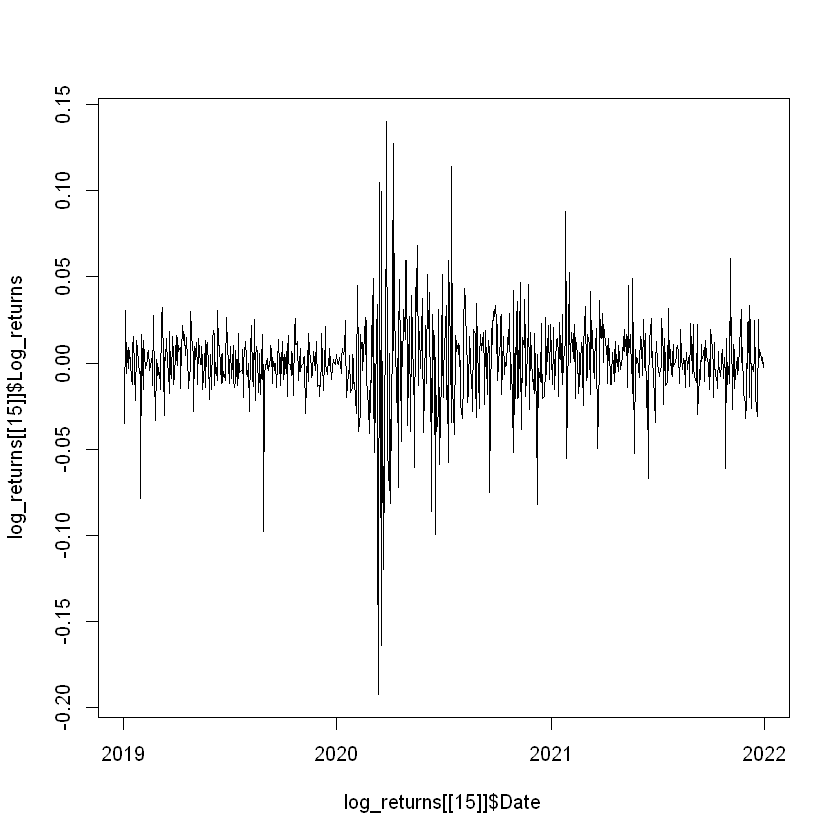

In [8]:
#Example of Log-Return series
plot(x=log_returns[[15]]$Date, y=log_returns[[15]]$Log_returns, type="l")

In [9]:
#Just some notes

#plot ACF and PACF of logrets? or logrets^2?
#lagrange multiplier test for ARCH effect? (arch.test)?
#alpha - effetc of past excess return (ret. different from mean), beta - effect of variance (volatility) from the previous period

---

### 2) Estimating GARCH(1,1) models

In this section, we estimate 100 GARCH(1,1) models (one for each stock). The GARCHes estimated are of standard form:

$
r_t = \mu_t + a_t \\
a_t = \sigma_t\epsilon_t \\
\sigma^2_t = \alpha_0 + \alpha_1a^2_{t-1} + \beta_1\sigma^2_{t-1}
$ where $(\alpha_1 + \beta_1) < 1$.

 For the estimation, we use functions from the ugarch package.

In [10]:
#Estimating GARCH(1,1) models and saving fitted objects in list
garch_list <- vector("list", length(tickers_data)) #empty list, to be filled with fitted-model objects

for(i in 1:length(tickers_data)){
    garch_spec <- ugarchspec(mean.model = list(armaOrder = c(0, 0)), variance.model = list(garchOrder = c(1, 1)))
    garch_fit <- ugarchfit(garch_spec, na.omit(log_returns[, i]))

    garch_list[[i]] <- garch_fit
}

### 3) Extracting and plotting alphas and betas

In this section, we extract the estimated parameters from fitted models and plot their histograms.

In [11]:
#Initializing an empty dataframe
coef_df <- data.frame(Firm = tickers, 
                    alphas = rep(NA, length(tickers_data)), 
                    betas = rep(NA, length(tickers_data)), 
                    ab_sum = rep(NA, length(tickers_data)))

#Filling the dataframe with the estimated aplphas, betas, and their sums
for(i in 1:length(tickers_data)){
    coef_df$alphas[i] <- as.numeric(coef(garch_list[[i]])[3])
    coef_df$betas[i] <- as.numeric(coef(garch_list[[i]])[4])
    coef_df$ab_sum[i] <- as.numeric(coef(garch_list[[i]])[3]) + as.numeric(coef(garch_list[[i]])[4])
}                    

Bellow, histograms are displayed. From the definition of the GARCH(1,1) model, we know that $\alpha + \beta < 1$. Keeping this information in mind, we can observe that estimated alphas attain relatively small values (most frequently between 0.1 and 0.2), while betas relatively large values (concentrated around 0.8). 

In the GARCH model, $\alpha$ represents the effect of the excess squared return $a^2$ in period $t-1$ on the volatility $\sigma^2$ in period $t$, and $\beta$ represents the effect of $\sigma^2_{t-1}$ on $\sigma^2_t$. Therefore, based on the models estimated we could assume that for most stocks, the effect of past excess returns on the volatility will be present, but not very strong, while the effect of volatility on itself will be dominant. This also supports empirically observed volatility clustering, according to which the large (small) price changes tends to be followed by large (small) price changes as well. 

From the histogram of $(\alpha+\beta)$ values, we can see that for the majority of fitted models the sum is close to 1 (mostly concentrated around 0.95). The condition $(\alpha_1 + \beta_1) < 1$ ensures that conditional variance of $a_t$, $\sigma^2_t$, does not diverge, but converge to unconditional variance $\alpha_0$ in infinity. Therefore, as the sum tends to be close to 1, we can assume that $\sigma^2_t$ will convergence only slowly, past mean corrected returns $a^2_{t-1}$ will play an important role, and/or the effect of $\sigma^2_{t-1}$ (variance clustering effect) will be prominent.

There are also outliers in the vectors of alphas and betas, but these are explored in the next section. These cause the distribution of alphas to be righ-skewed while the distribution of betas and the sums to be left-skewed.

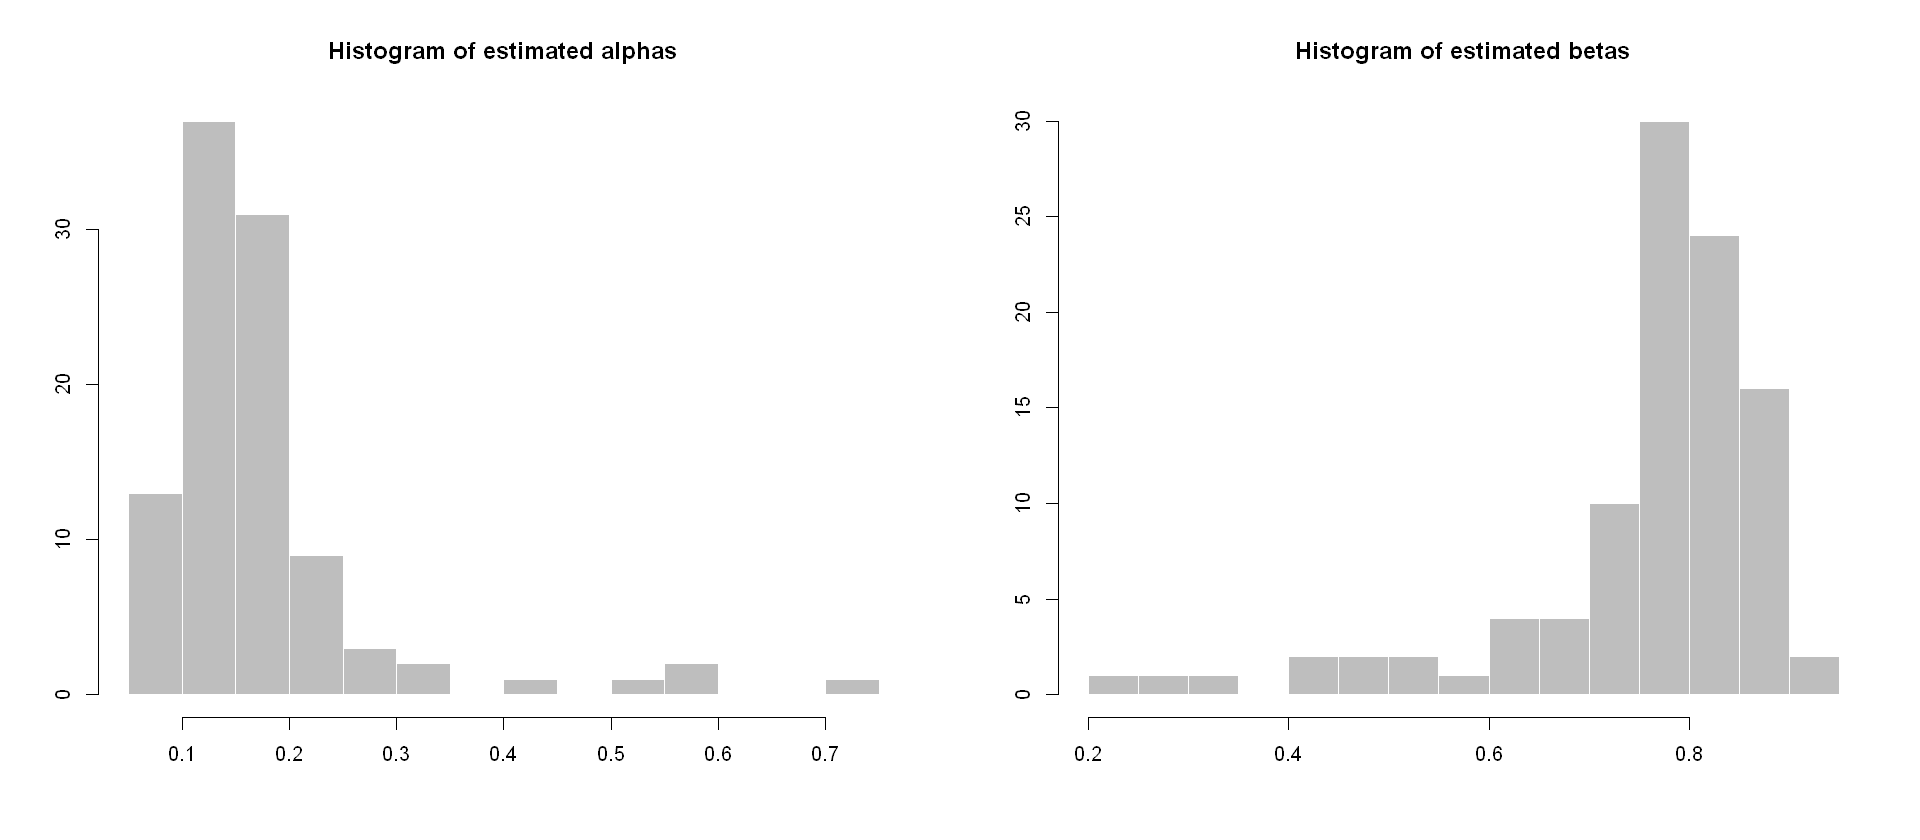

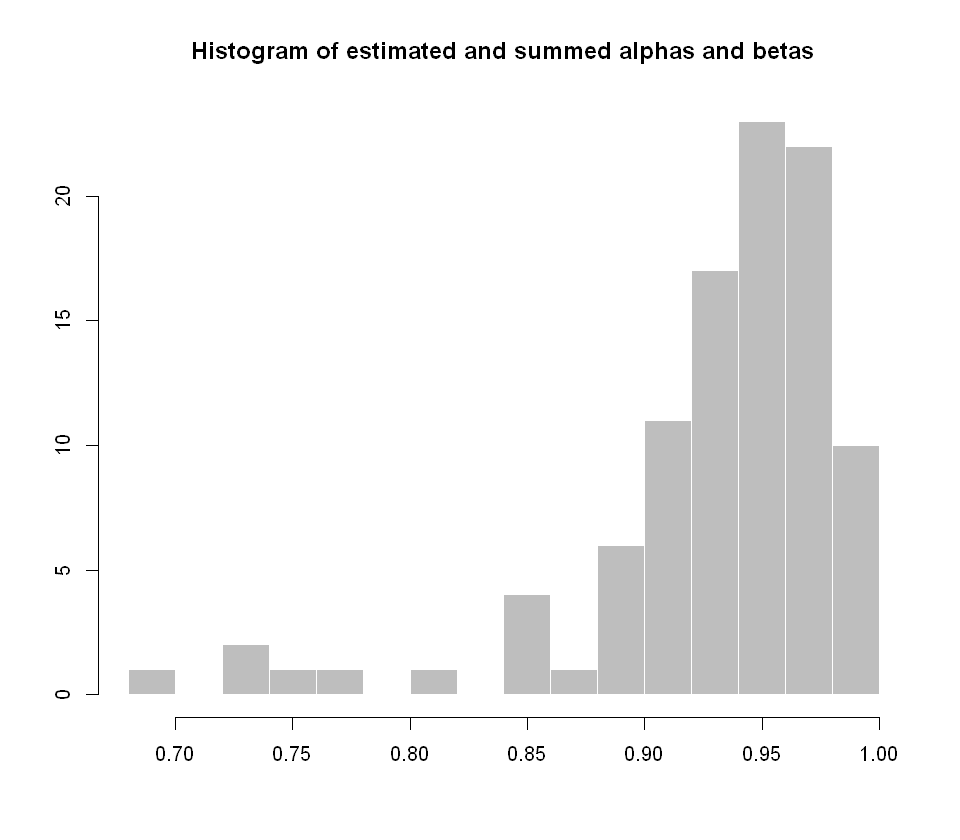

In [16]:
#ploting the crossection of coefficients
options(repr.plot.width = 16, repr.plot.height = 7)
par(mfrow = c(1, 2))
hist(coef_df$alphas, breaks = "FD", border = F, col = "grey", main = "Histogram of estimated alphas", xlab = "", ylab = "")
hist(coef_df$betas, breaks = "FD", border = F, col = "grey", main = "Histogram of estimated betas", xlab = "", ylab = "")
options(repr.plot.width = 8, repr.plot.height = 7)
par(mfrow = c(1, 1))
hist(coef_df$ab_sum, breaks = "FD", border = F, col = "grey", main = "Histogram of estimated and summed alphas and betas", xlab = "", ylab = "")

### 4) Maximum estimated coefficients

Following directly from the pevious section, here we show smallest and largest values of estimated parameters.

In [17]:
#alpha
m_a <- max(coef_df$alphas)
m_a_name <- symbols2$Name[symbols2$Symbol == coef_df$Firm[match(m_a, coef_df$alphas)]]
m_a_min <- min(coef_df$alphas)
m_a_name_min <- symbols2$Name[symbols2$Symbol == coef_df$Firm[match(m_a_min, coef_df$alphas)]]

#beta
m_b <- max(coef_df$betas)
m_b_name <- symbols2$Name[symbols2$Symbol == coef_df$Firm[match(m_b, coef_df$betas)]]
m_b_min <- min(coef_df$betas)
m_b_name_min <- symbols2$Name[symbols2$Symbol == coef_df$Firm[match(m_b_min, coef_df$betas)]]

#sums
m_ab <- max(coef_df$ab_sum)
m_ab_name <- symbols2$Name[symbols2$Symbol == coef_df$Firm[match(m_ab, coef_df$ab_sum)]]
m_ab_min <- min(coef_df$ab_sum)
m_ab_name_min <- symbols2$Name[symbols2$Symbol == coef_df$Firm[match(m_ab_min, coef_df$ab_sum)]]

#alpha
print(paste("Maximum estimated alpha:", m_a, "for firm", m_a_name))
print(paste("Minimum estimated alpha:", m_a_min, "for firm", m_a_name_min))

#beta
print(paste("Maximum estimated beta:", m_b, "for firm", m_b_name))
print(paste("Minimum estimated beta:", m_b_min, "for firm", m_b_name_min))

#sums
print(paste("Maximum estimated sum:", m_ab, "for firm", m_ab_name))
print(paste("Minimum estimated sum:", m_ab_min, "for firm", m_ab_name_min))

[1] "Maximum estimated alpha: 0.730018062601233 for firm Hasbro Inc."
[1] "Minimum estimated alpha: 0.0575180896952958 for firm Newmont Mining Corp. (Hldg. Co.)"
[1] "Maximum estimated beta: 0.916040547794923 for firm Ryder System"
[1] "Minimum estimated beta: 0.231075915390209 for firm Hasbro Inc."
[1] "Maximum estimated sum: 0.998999981751652 for firm Host Hotels & Resorts"
[1] "Minimum estimated sum: 0.698998363316432 for firm Intel Corp."


Interpretation of maximal and minimal values of estimated coefficients stems from their properties described above. 

* In the case of Hasbro Inc. (largest alpha and smallest beta), we can assume that variance of log-returns on the firm's stock will be heavily affected by past mean-corrected returns, while the volatility clustering effect will be weak.

* For the Newmont Mining Corp. (smallest alpha), we could expect the variance $\sigma^2_t$ to be only very weakly dependent on the past returns.

* Rider Systems' return volatility will likely suffer of strong volatility clustering effect, as values of $\sigma^2_t$ will probably be strongly affected by $\sigma^2_{t-1}$ (largest beta).

* For the Host Hotels & Resorts (largest sum of alpha and beta), we can assume the volatility converge to unconditional volatility very slowly, the effect of past returns and volatility clustering being strong.

* On the other hand, in case of Intel Corp. (smallest sum), the $\sigma^2_t$ will likely converge to $\alpha_0$, and the effect of $a_{t-1}$ and volatility clustering will be weak.

### 5) Estimated volatility averaged 

Here, we extract the estimated volatilities from the GARCH(1,1) models, and then calculate the median, 5%, and 95% quantiles for each day.

In [22]:
#We extract the volatility for the first stock and then merge it with the second one. Subsequently, we loop through the rest
volatilities <- merge.xts(sigma(garch_list[[1]]), sigma(garch_list[[2]]))
for (iter in 3:length(garch_list)) {
    volatilities <- merge.xts(volatilities, sigma(garch_list[[iter]]))
}

Now, we can calculate the quantiles.

In [24]:
#Five percent
five_percent <- apply.daily(volatilities, function(x) quantile(c(x), probs = 0.05, na.rm = TRUE))
#Median
medians <- apply.daily(volatilities, function(x) quantile(c(x), probs = 0.5, na.rm = TRUE))
#Ninety-five percent
ninety_five_percent <- apply.daily(volatilities, function(x) quantile(c(x), probs = 0.95, na.rm = TRUE))

And finally, we plot the estimated "market" volatility. The median volatility is shown in black while the 5% and 95% quantiles in red.

To comment on the volatility values themselves, we can observe that at the first quarter of 2020, there was an extreme spike in market volatility very likely caused by the break-out of the Covid-19. Since then, variance slowly returned to its pre-covid values. We can also observe volatility clustering from the plot, since an increased volatility is likely to be again followed by increased volatility.

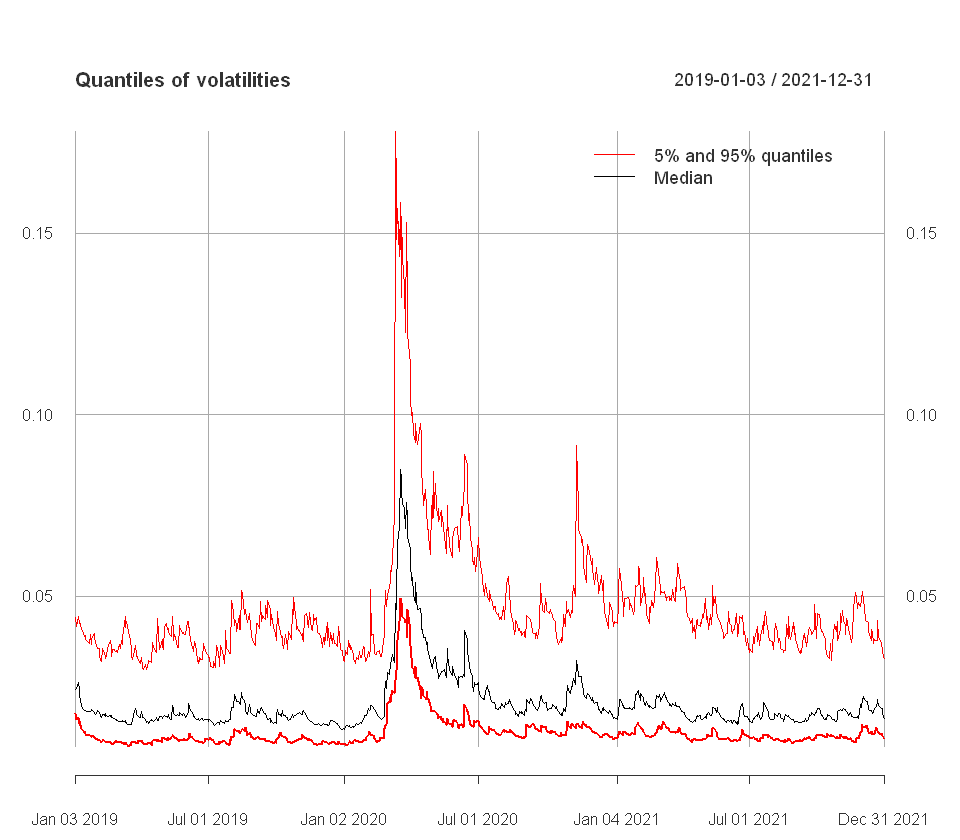

In [38]:
#Plotting
plot_holder <- plot(five_percent, col = "red", ylim = c(min(five_percent, medians, ninety_five_percent),max(five_percent, medians, ninety_five_percent)), main = "Quantiles of volatilities")
plot_holder <- lines(medians, col = "black")
plot_holder <- lines(ninety_five_percent, col = "red")
plot_holder <- addLegend("topright", on=1, legend.names = c("5% and 95% quantiles", "Median"), col=c("red", "black"), lty=c(1, 1))
plot_holder

---

In [13]:
#Extracting the volatilities
volatilities <- vector("list", length(garch_list))
for (iter in 1:length(garch_list)) {
    vol <- rep(NA, length(index(na.omit(tickers_data[[iter]]))))
    vol[2:length(vol)] <- as.numeric(sigma(garch_list[[iter]]))
    volatilities[[iter]] <- data.frame(Date=index(na.omit(tickers_data[[iter]])),Volatility=vol)
}

In [14]:
#Computing the quantiles
days <- seq(from = as.Date("2019-01-01"), to = as.Date("2021-12-31"), by="day")
five_percent <- rep(NA, length(days))
medians <- rep(NA, length(days))
ninety_five_percent <- rep(NA, length(days))
for (iter_day in 1:length(days)) { #For each day
    daily_vol <- rep(NA, 100) #Empty vector for daily volatilities accross tickers
    for (iter_ticker in 1:100) { #For each ticker check if the value exists
        if (days[iter_day] %in% volatilities[[iter_ticker]]$Date) {
            #daily_vol[iter_ticker] <- volatilities[[iter_ticker]]$Volatility[iter_day] #corecting bug that was on this line (subseting vector of length 757 by numbers 757+)
            daily_vol[iter_ticker] <- volatilities[[iter_ticker]]$Volatility[volatilities[[iter_ticker]]$Date == days[iter_day]]
    } else {
        daily_vol[iter_ticker] <- NA
    }
    }
    five_percent[iter_day] <- quantile(daily_vol, probs = 0.05, na.rm = TRUE)
    medians[iter_day] <- quantile(daily_vol, probs = 0.5, na.rm = TRUE)
    ninety_five_percent[iter_day] <- quantile(daily_vol, probs = 0.95, na.rm = TRUE)
    #print(summary(daily_vol))
}

In the following cell, the estimated "market" volatility is estimated. The mean volatility is shown in black, the 5% and 95% quantiles in gray, therefore together the plot shows a "90% confidence band" for the true market volatility (please keep in mind that such intepretation is just a heuristics).

To comment on the volatility values themselves, we can observe that at the first quarter of 2020, there was an extreme spike in market volatility very likely caused by the break-out of the Covid-19. Since then, variance slowly returned to its pre-covid values. We can also observe volatility clustering from the plot, since an increased volatility is likely to be again followed by increased volatility.

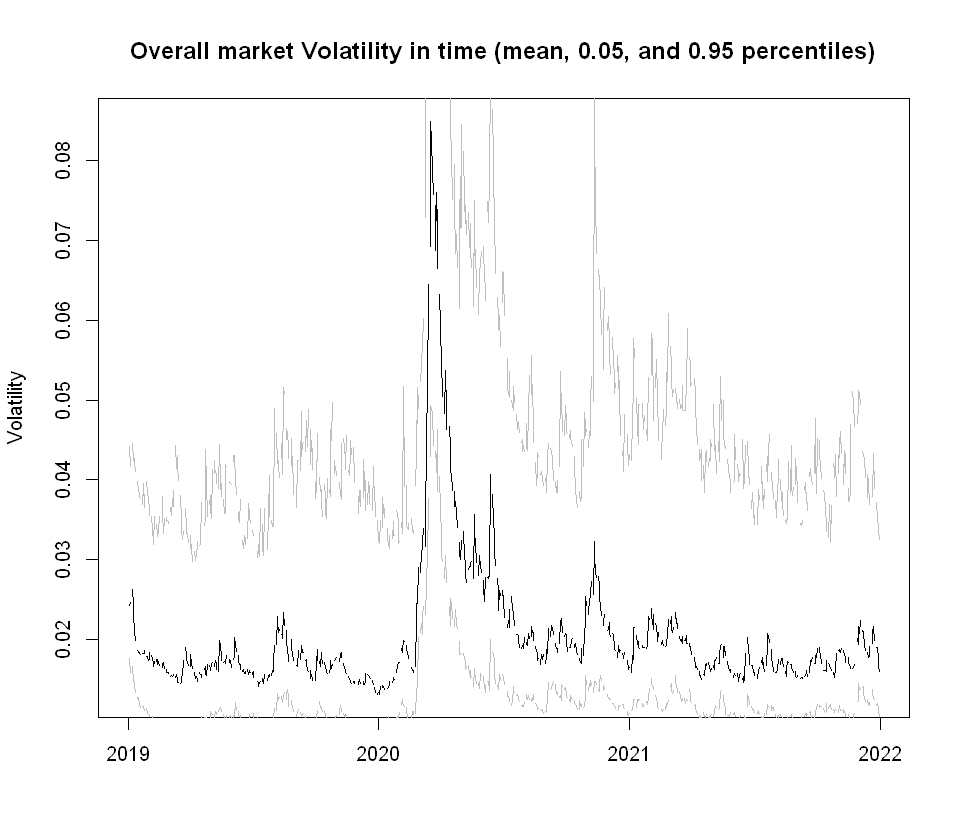

In [15]:
plot(x = days, y = medians, type = "l", main = "Overall market Volatility in time (mean, 0.05, and 0.95 percentiles)", xlab = "", ylab="Volatility")

lines(x = days, y = five_percent, type = "l", col = "grey")
lines(x = days, y = ninety_five_percent, type = "l", col = "grey")

---

### Problem 2

Firstly, we will compute the means form the logarithmic returns obtained above. For each day, we will average all the observations available from the 100 stocks.

In [39]:
#Computing the means
log_returns_means <- apply.daily(log_returns, function(x) mean(c(x), na.rm = TRUE))

Next, we quickly inspect the summary. We can see that the mean is very close to zero and the first and third quartiles have a similar distance from the mean. However, the histogram hints that the tails are quite heavy and the kurtosis is also likely higher than in a normal distribution. Moreover, the line plot indicates that the series might have a constant mean, however, we need to test it emphirically. With this in mind, we proceed with the analysis.

     Index            log_returns_means   
 Min.   :2019-01-03   Min.   :-0.1367964  
 1st Qu.:2019-10-02   1st Qu.:-0.0060408  
 Median :2020-07-04   Median : 0.0011411  
 Mean   :2020-07-03   Mean   : 0.0006761  
 3rd Qu.:2021-04-05   3rd Qu.: 0.0081388  
 Max.   :2021-12-31   Max.   : 0.1169785  

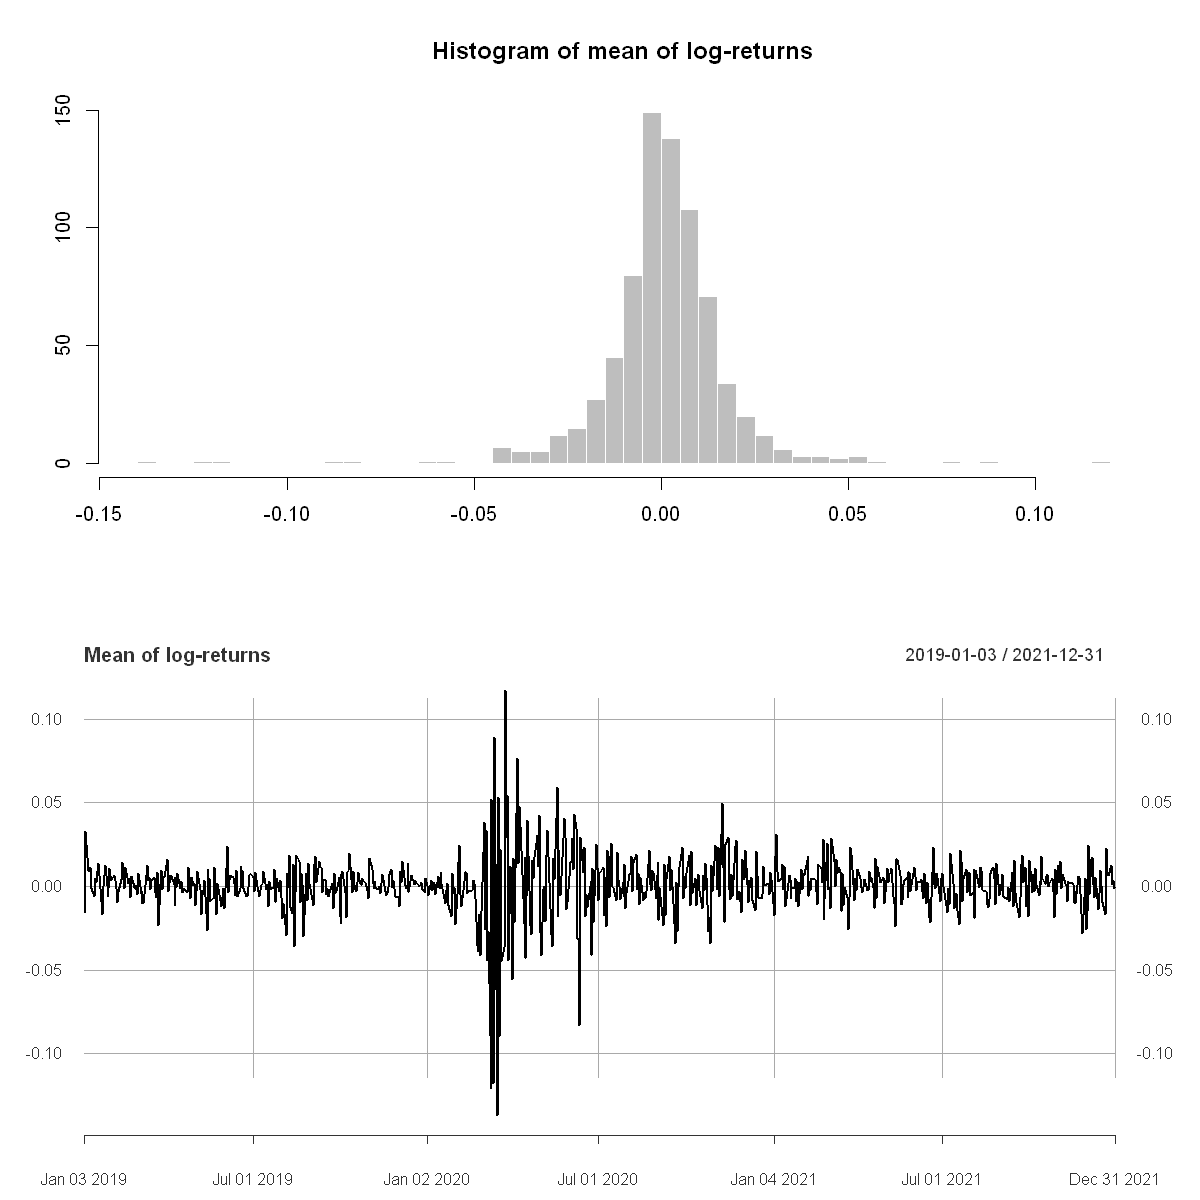

In [45]:
summary(log_returns_means)
log_returns_means <- na.omit(log_returns_means) #Dropping one missing observation (it is the first one for which one the return is obviously unavailable)
par(mfrow = c(2,1))
options(repr.plot.width = 10, repr.plot.height = 10)
hist(log_returns_means, border = F, xlab = "", ylab = "", main = "Histogram of mean of log-returns", col = "grey", breaks = "FD")
plot(log_returns_means, main = "Mean of log-returns")

As discussed above, we need to investigate the weak (covariance) stationarity of the series. Therefore, we will perform the Augmented Dicker-Fulley test with the null hypothesis that the series contains a unit root. As can be seen from the results, we strongly reject the null hypothesis in favor of stationarity. Since the series is already differenced, this does not come as a surprise. However, we needed to make sure whether the adjusted closing price was not integrated of order higher than one.

In [46]:
#ADF test
adf.test(log_returns_means)

Warning message in adf.test(log_returns_means):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  log_returns_means
Dickey-Fuller = -7.3875, Lag order = 9, p-value = 0.01
alternative hypothesis: stationary


In the following step we will inspect the autocorrelation and partial autocorrelation function.

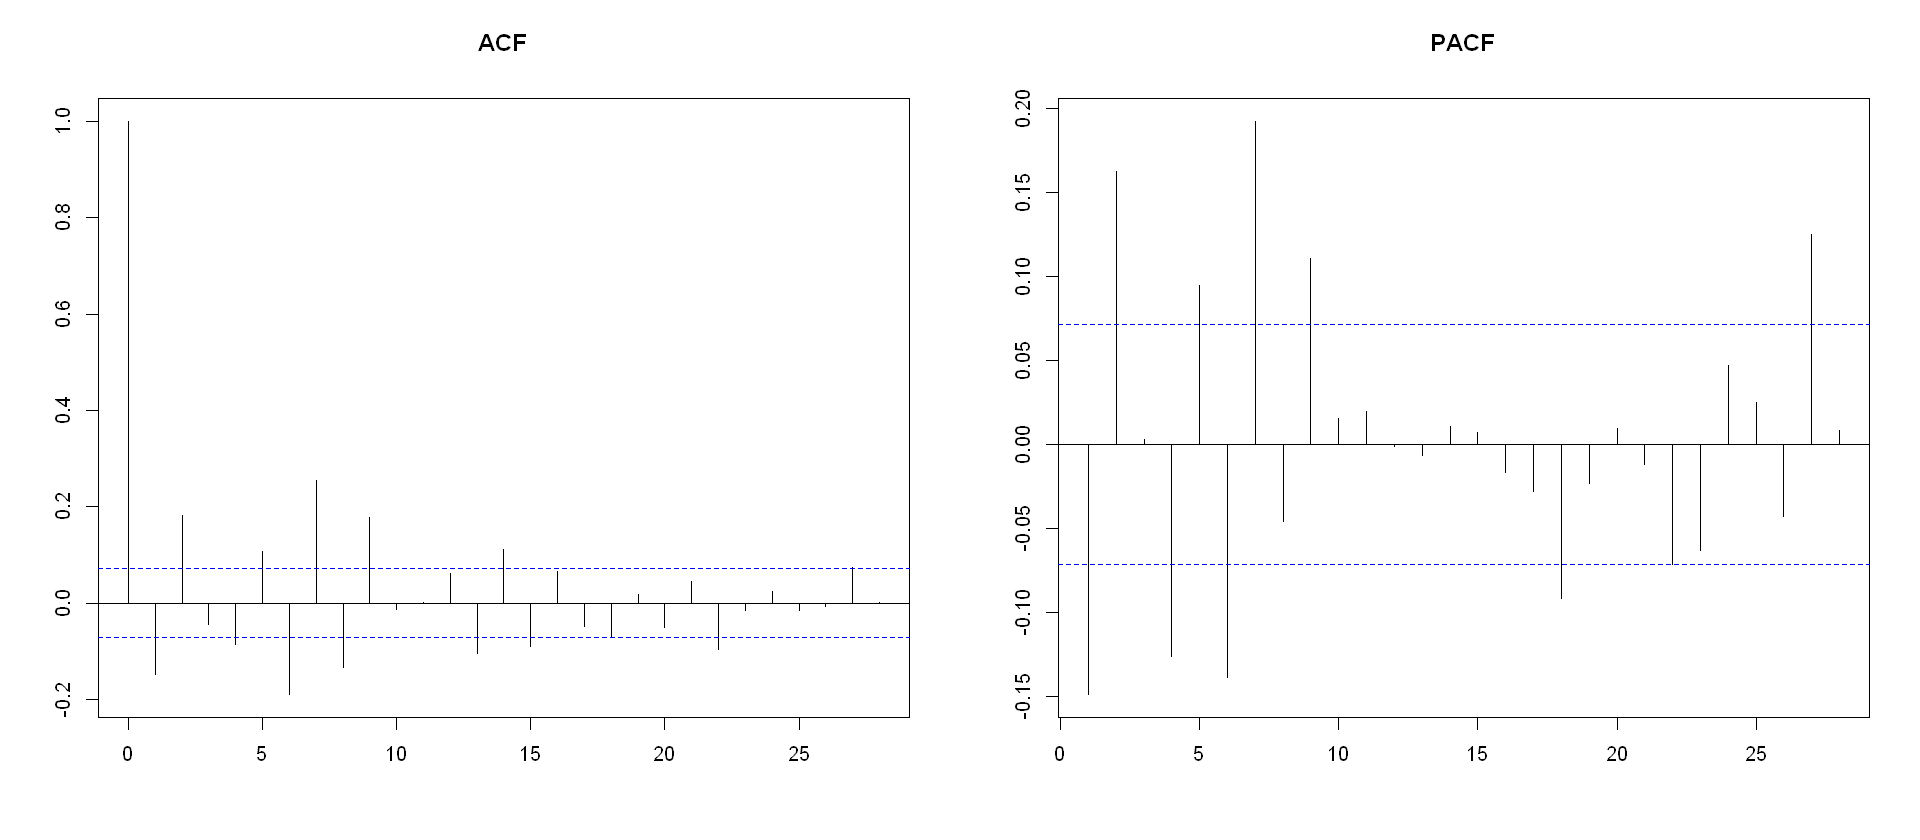

In [47]:
#ACF and PACF
par(mfrow=c(1,2))
options(repr.plot.width = 16, repr.plot.height = 7)
acf(log_returns_means, xlab = "", ylab = "", main = "ACF")
pacf(log_returns_means, xlab = "", ylab = "", main = "PACF")

As can be seen, there appear to be some dependencies in the first nine lags. The signs of the correlations are alternating which suggests that the coefficient of the first lag might be negative. Since it would be unreasonable to estimate ARMA(9,0) (the order is to high and we want as simple model as possible), we will try ARMA(4,0) first instead. We will see how we are doing with regards to removing the dependencies and then adjust the model, accordingly.

In [40]:
#ARMA(4,0)
arma40 <- Arima(log_returns_means, order = c(4, 0, 0))
summary(arma40)

Series: log_returns_means 
ARIMA(4,0,0) with non-zero mean 

Coefficients:
          ar1     ar2      ar3      ar4   mean
      -0.1250  0.1839  -0.0126  -0.1264  7e-04
s.e.   0.0361  0.0364   0.0364   0.0361  6e-04

sigma^2 = 0.0002969:  log likelihood = 1999.87
AIC=-3987.73   AICc=-3987.62   BIC=-3959.96

Training set error measures:
                        ME       RMSE        MAE       MPE     MAPE      MASE
Training set -8.909985e-07 0.01717405 0.01097132 -1046.646 1328.901 0.6860452
                 ACF1
Training set 0.012194

A quick glimpse at the results reveals that only the third lag is not statistically significant. In addition, our hypothesis about the negative sign of the first coefficient turned out to be right. Neverthless, we need to assess the performance of the model. Firstly, we will, again, take a look at ACF and PACF but this time of the model's residuals.

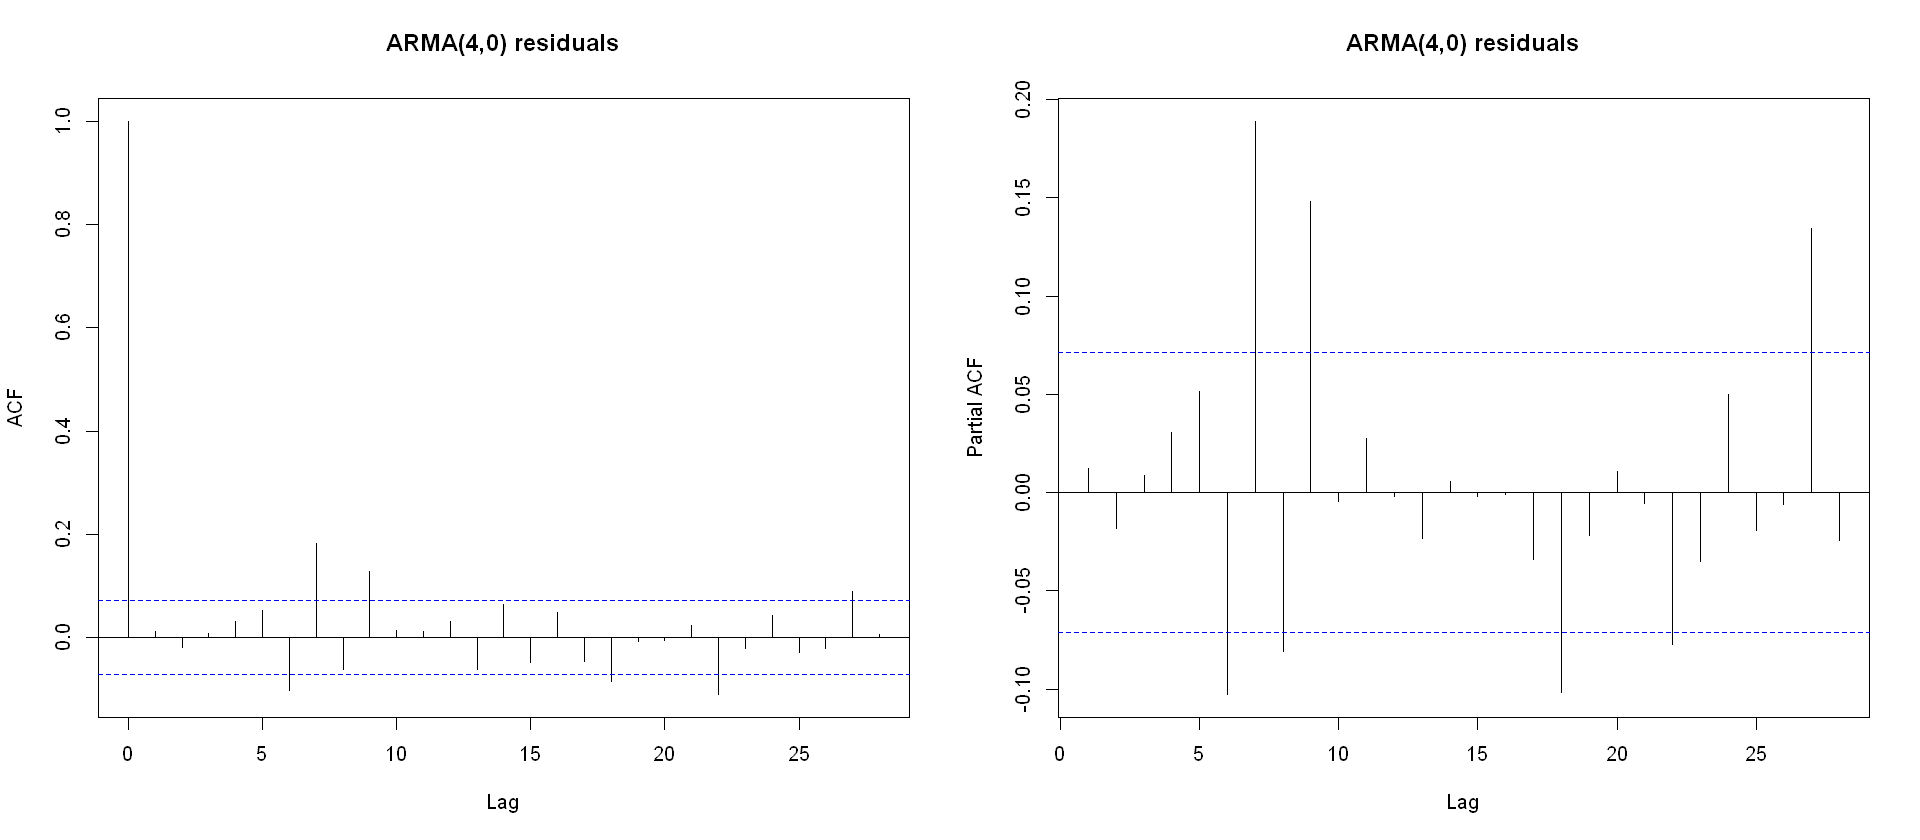

In [42]:
#ACF and PACF
par(mfrow=c(1,2))
options(repr.plot.width = 16, repr.plot.height = 7)
acf(arma40$residuals, main = "ARMA(4,0) residuals")
pacf(arma40$residuals, main = "ARMA(4,0) residuals")

As can be seen, we successfully removed some dependencies, however, there still appears to be some left. We can confirm that using the Ljung-Box test which test the null hypothesis that the time series is independent.

In [44]:
#Ljung-Box test
for (lag_order in c(4, 8, 12)) {
    print(Box.test(arma40$residuals, type = "Ljung-Box", lag = lag_order))
}


	Box-Ljung test

data:  arma40$residuals
X-squared = 1.1662, df = 4, p-value = 0.8836


	Box-Ljung test

data:  arma40$residuals
X-squared = 39.512, df = 8, p-value = 3.949e-06


	Box-Ljung test

data:  arma40$residuals
X-squared = 52.934, df = 12, p-value = 4.232e-07



The results suggests that we indeed succeded in removing the autocorrelation up to the fourth order, however, we reject the null for orders 8 and 12. Thereofore, we need to adjust the model accordingly. Given that the autoregressive order is already quite high, we will try to introduce the moving average process. We will start with an ARMA(4,1).

In [45]:
#ARMA(4,1)
arma41 <- Arima(log_returns_means, order = c(4, 0, 1))
summary(arma41)

Series: log_returns_means 
ARIMA(4,0,1) with non-zero mean 

Coefficients:
          ar1     ar2     ar3      ar4     ma1   mean
      -0.8966  0.0920  0.1094  -0.1546  0.8292  7e-04
s.e.   0.0526  0.0489  0.0491   0.0386  0.0413  6e-04

sigma^2 = 0.0002813:  log likelihood = 2020.66
AIC=-4027.33   AICc=-4027.18   BIC=-3994.93

Training set error measures:
                        ME     RMSE       MAE       MPE     MAPE      MASE
Training set -2.570698e-06 0.016704 0.0109366 -985.5916 1286.494 0.6838743
                    ACF1
Training set 0.006358275

As can be seen, the newly introduced moving average process of order one is highly statistically significant. In addition, even the third lag of the AR proccess became significant. We will assess the performace immediately.

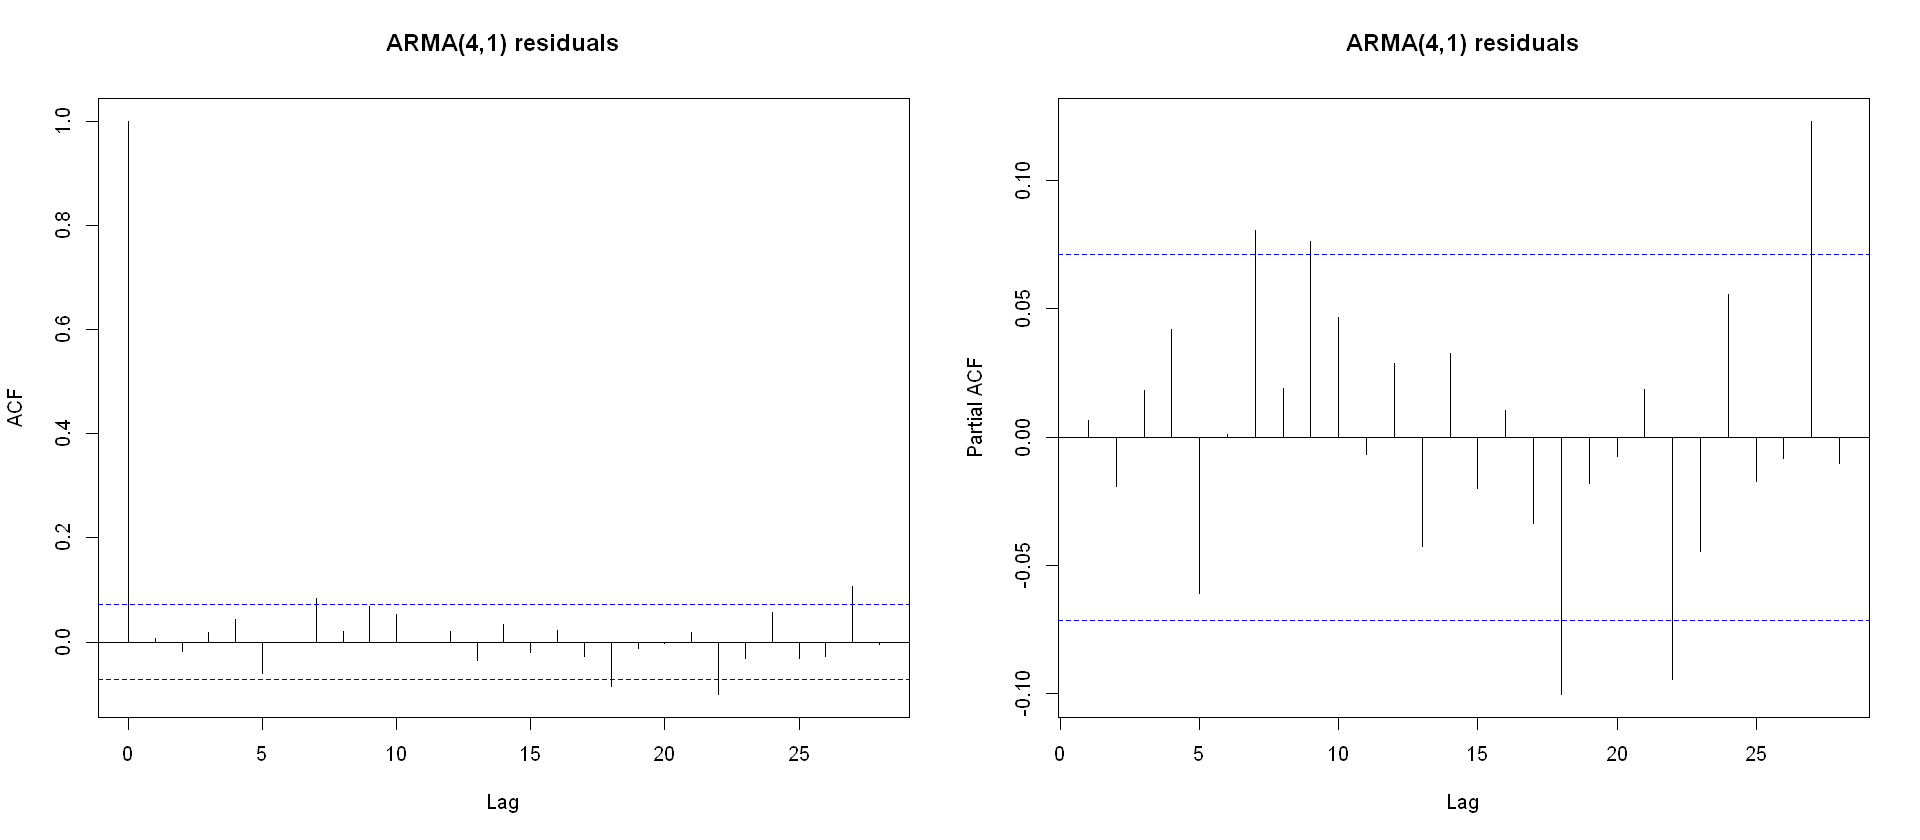

In [46]:
#ACF and PACF
par(mfrow=c(1,2))
options(repr.plot.width = 16, repr.plot.height = 7)
acf(arma41$residuals, main = "ARMA(4,1) residuals")
pacf(arma41$residuals, main = "ARMA(4,1) residuals")

The ACF suggests that we are doing even better job at removing the dependencies accross the residuals. The PACF, however, still shows some significant correlations in lags of higher order. Again, we will test this empirically.

In [53]:
#Ljung-Box test
for (lag_order in c(8, 12, 18, 22)) {
    print(Box.test(arma41$residuals, type = "Ljung-Box", lag = lag_order))
}


	Box-Ljung test

data:  arma41$residuals
X-squared = 10.411, df = 8, p-value = 0.2374


	Box-Ljung test

data:  arma41$residuals
X-squared = 16.373, df = 12, p-value = 0.1747


	Box-Ljung test

data:  arma41$residuals
X-squared = 25.134, df = 18, p-value = 0.1213


	Box-Ljung test

data:  arma41$residuals
X-squared = 33.484, df = 22, p-value = 0.05539



The results show that we removed almost all dependencies and there is only some correlation left in the lags of a very high order. Considering the very high statistical significance of the MA component, we will add one more order and estimate the last model as ARMA(4,2).

In [54]:
#ARMA(4,2)
arma42 <- Arima(log_returns_means, order = c(4, 0, 2))
summary(arma42)

Series: log_returns_means 
ARIMA(4,0,2) with non-zero mean 

Coefficients:
          ar1      ar2     ar3      ar4     ma1     ma2   mean
      -1.4626  -0.5058  0.1417  -0.0200  1.4101  0.5629  7e-04
s.e.   0.1216   0.1337  0.0687   0.0552  0.1164  0.1095  6e-04

sigma^2 = 0.000279:  log likelihood = 2024.24
AIC=-4032.47   AICc=-4032.28   BIC=-3995.45

Training set error measures:
                        ME       RMSE        MAE      MPE     MAPE      MASE
Training set -3.688585e-06 0.01662458 0.01087042 -660.324 961.1669 0.6797362
                     ACF1
Training set 0.0002369447

The output above presents some very interesting results. The newly introduced coefficient is highly stastically signficant but we lost the significance of the fourth lag of the AR process. We can also observe a large increase in the magnitude of the coefficient on the first lag. The perfomance assessment follows.


	Box-Ljung test

data:  arma42$residuals
X-squared = 7.1046, df = 8, p-value = 0.5254


	Box-Ljung test

data:  arma42$residuals
X-squared = 12.365, df = 12, p-value = 0.4168


	Box-Ljung test

data:  arma42$residuals
X-squared = 18.644, df = 18, p-value = 0.414


	Box-Ljung test

data:  arma42$residuals
X-squared = 23.484, df = 22, p-value = 0.3748



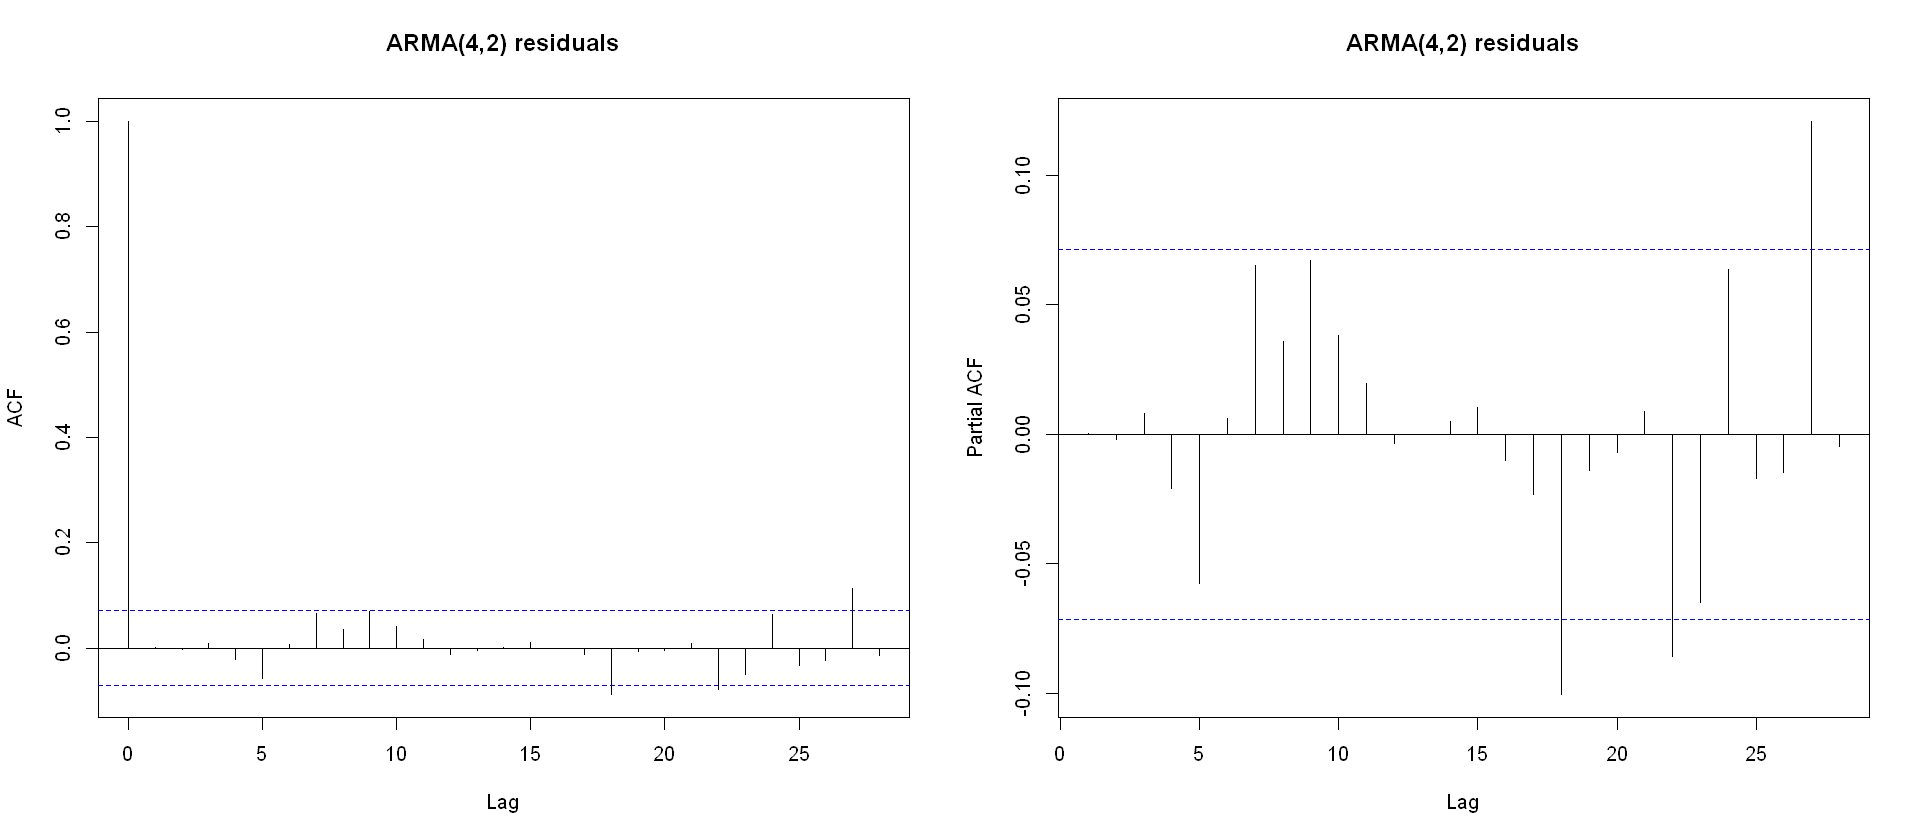

In [57]:
#ACF and PACF
par(mfrow=c(1,2))
options(repr.plot.width = 16, repr.plot.height = 7)
acf(arma42$residuals, main = "ARMA(4,2) residuals")
pacf(arma42$residuals, main = "ARMA(4,2) residuals")

#Ljung-Box test
for (lag_order in c(8, 12, 18, 22)) {
    print(Box.test(arma42$residuals, type = "Ljung-Box", lag = lag_order))
}

The last model brings the most satisfying results so far in terms of removing the dependencies among the residuals. Even though the PACF still shows some sign of autocorrelation in very high orders, we deem this as satisfactory. In fact, the result of the previous model may even be sufficient taking into account its simplicity. What is left is to compare the information criteria to select the best model.

In [71]:
#AIC, AICc, BIC
inf_crit <- as.data.frame(matrix(ncol = 4, nrow = 3))
colnames(inf_crit) <- c("Model", "AIC", "AICc", "BIC")
armas <- c("arma40", "arma41", "arma42")
inf_crit[, 1] <- armas
for (iter in 1:3) {
    inf_crit[iter, 2] <- get(armas[iter])[["aic"]]
    inf_crit[iter, 3] <- get(armas[iter])[["aicc"]]
    inf_crit[iter, 4] <- get(armas[iter])[["bic"]]
}
inf_crit

Model,AIC,AICc,BIC
<chr>,<dbl>,<dbl>,<dbl>
arma40,-3987.730,-3987.618,-3959.962
arma41,-4027.330,-4027.180,-3994.933
arma42,-4032.473,-4032.280,-3995.449


Based on the comparison, we can conclude that ARMA(4,2) is the the best model out of the three. Even though BIC is minimized for ARMA(4,1), the magnitude of the difference is quite small as compared to other criteria. In addition, given the large size of our sample, we would likely rely more on AIC since BIC penalizes maybe too much in large samples. ARMA(4,2) is a fairly complex model, however, it does a pretty good job at removing the dependencies in the residuals.

We can compare our choice to the output of the ``auto.arima`` function which selects the best model based on a given information criteria.

In [77]:
#auto.arima
for (i in c("aicc","aic","bic")){
    model <- auto.arima(log_returns_means, stationary = T, ic = i)
    print(paste("Model chosen by ",i,": ","ARMA(",model$arma[1],",",model$arma[2],")",sep = ""))
}


[1] "Model chosen by aicc: ARMA(4,2)"
[1] "Model chosen by aic: ARMA(4,2)"
[1] "Model chosen by bic: ARMA(4,1)"


Since the output is essentially the same as our analysis, we can be quite satisfied with the results.